In [1]:
torch.setdefaulttensortype('torch.FloatTensor')

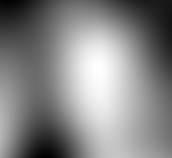

In [2]:
require 'image'
filter = image.gaussian(100)
filter:div(filter:sum())
input = image.convolve(image.fabio(), filter)
itorch.image(input)

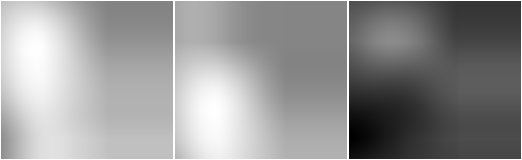

In [3]:
Integral = nil
IntegralSmartNorm = nil
debug.getregistry()['Integral'] = nil 
debug.getregistry()['IntegralSmartNorm'] = nil 
package.loaded['Integral'] = nil
package.loaded['IntegralSmartNorm'] = nil

require 'nn'
require 'IntegralSmartNorm'

refInt = IntegralSmartNorm(2, input:size(1), input:size(2)):type(input:type())

refRects = {{20, 20, 100, 100}, {-40, -40, 60, 60}}

for k = 1,2 do
    refInt.xMin[k], refInt.xMax[k], refInt.yMin[k], refInt.yMax[k] = table.unpack(refRects[k])
end

targetSeparate = refInt:forward(input)
target = targetSeparate[1] - targetSeparate[2]
itorch.image{targetSeparate[1], targetSeparate[2], target}

In [66]:
require 'WindowDebugger'

wDeb = WindowDebugger()

int = IntegralSmartNorm(2, input:size(1), input:size(2)):type(input:type())
int.exact = true

conv = nn.SpatialConvolution(2, 1, 1,1,1,1)
conv.weight[1][1][1][1] = 1
conv.weight[1][1][1][1] = -1
conv.bias[1] = 0 

net = nn.Sequential()
net:add(int)
net:add(conv)

crit = nn.MSECriterion():type(input:type())

params, gradParams = int:getParameters()

In [67]:
require 'optim'

optimState = {
    learningRate = 3e3,
    momentum = 0.6,
    nesterov = true,
    dampening = 0
}

In [68]:
outputDir = 'Test-simple-Haar/1/'
os.execute('mkdir "' .. outputDir .. '" -p')
    
logger = optim.Logger(outputDir .. 'accuracy.log')
logger:setNames{'Loss'}
logger:style{'-'}

In [69]:
for k = 1,150 do
    local feval = function(x)
        gradParams:zero()
--         assert(0 == int.gradXMax[1])
        local pred = net:forward(input)
        local loss = crit:forward(pred, target)
        local dloss_doutputs = crit:backward(pred, target)
        net:backward(input, dloss_doutputs)
--         print(int.gradXMax[1])
        
        return loss, gradParams
    end

    local _, loss = optim.sgd(feval, params, optimState)
    logger:add{loss[1]}
    
    wDeb:add(int)
    
    logger:plot()
end

In [70]:
wDeb:exportVideo(outputDir .. 'int.avi', refRects)